In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from utils import *

import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
batch_size = 128

data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers = 8)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False, num_workers= 8)

In [5]:
# Hyper-parameters
image_size = 784
num_epochs = 15
learning_rate = 1e-3

# VAE for MNIST

The goal of this notebook is to explore the basic VAE architecture, with MNIST dataset.

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy.

In [7]:
import torch
from models.vae import VanillaVAE
from models.vae_lightning import VAELit

# vae = VanillaVAE(in_channels=image_size, hidden_dims=[400])
vae = VanillaVAE(in_channels=image_size, hidden_dims=[1000, 500, 250], latent_dim=30)
try:
	vae_lit = VAELit.load_from_checkpoint(model=vae, checkpoint_path='./lightning_logs/version_1/checkpoints/epoch=14-step=7035.ckpt')
	print('checkpoint loaded')
except:
	vae_lit = VAELit(model=vae)
	print('new model built')

checkpoint loaded


In [8]:
print(vae_lit)

VAELit(
  (model): VanillaVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=1000, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Linear(in_features=1000, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (2): Linear(in_features=500, out_features=250, bias=True)
    )
    (fc_mu): Linear(in_features=250, out_features=30, bias=True)
    (fc_logsd): Linear(in_features=250, out_features=30, bias=True)
    (decoder): Sequential(
      (0): Sequential(
        (0): Linear(in_features=30, out_features=250, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Linear(in_features=250, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Linear(in_features=500, out_features=1000, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
     

In [12]:
import pytorch_lightning as pl
trainer = pl.Trainer(max_epochs=num_epochs,
											accelerator='gpu',
											devices=1, 
											enable_progress_bar=True,
                      )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [13]:
trainer.fit(vae_lit, train_dataloaders=data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | VanillaVAE | 2.8 M 
-------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.379    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

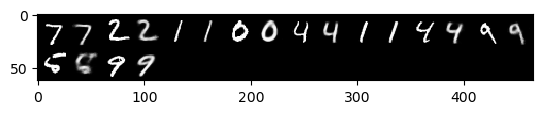

In [17]:
plot_reconstruction(vae_lit.model, test_loader)

Let's see now how our network generates new samples.

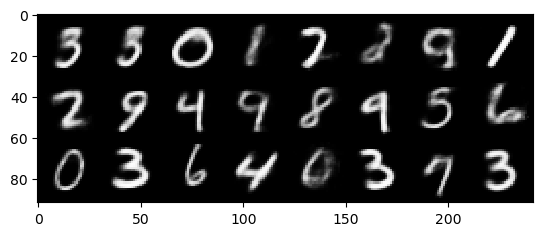

In [18]:
plot_generation(vae_lit.model)

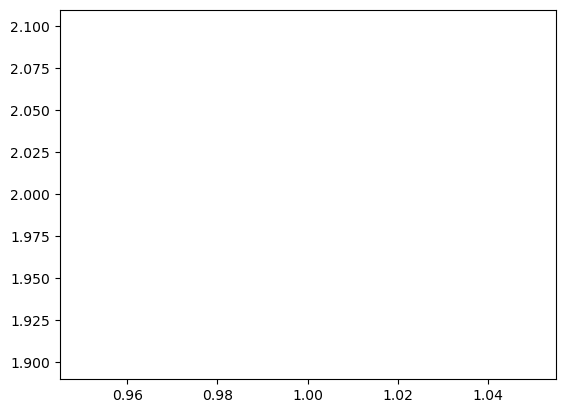

In [15]:
plt.plot([1],[2])

# CVAE for MNIST

Use labels in CVAE. The idea is to modify slightly the architecture above by feeding a onehot version of the label to the decoder in addition to the code computed by the encoder. 

First code a function transforming a label in its onehot encoding. This function will be used in the training loop (not in the architecture of the neural network).

In [ ]:
n_classes = 10
def l_2_onehot(labels,nb_digits=n_classes):
    # take labels (from the dataloader) and return labels onehot-encoded
    label_onehot = torch.FloatTensor(labels.shape[0], nb_digits)
    label_onehot.zero_()
    label_onehot.scatter_(1, labels.view(-1,1), 1)
    label_onehot = label_onehot.to(device)
    return label_onehot


Test it on a batch.

In [ ]:
(x,labels) = next(iter(data_loader))

In [ ]:
labels

tensor([9, 5, 5, 4, 7, 2, 5, 0, 3, 3, 2, 1, 8, 8, 7, 8, 4, 6, 8, 1, 8, 3, 5, 6,
        8, 2, 5, 7, 6, 2, 4, 7, 6, 3, 0, 3, 8, 0, 8, 9, 5, 3, 5, 4, 9, 5, 8, 2,
        7, 2, 7, 7, 5, 8, 8, 1, 7, 1, 3, 5, 4, 0, 1, 5, 0, 0, 4, 2, 1, 8, 2, 8,
        3, 0, 2, 2, 5, 7, 6, 9, 5, 0, 9, 5, 4, 1, 2, 0, 0, 1, 0, 0, 7, 4, 1, 0,
        6, 9, 8, 2, 2, 1, 4, 8, 6, 4, 0, 4, 0, 4, 1, 8, 5, 0, 1, 1, 0, 9, 8, 3,
        2, 1, 9, 7, 4, 7, 0, 1])

In [ ]:
l_2_onehot(labels)

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

Modifiy the architecture of the VAE where the decoder takes as input the random code concatenated with the onehot encoding of the label.

Test new model on a batch:

In [7]:
import torch
from models.cvae import CVAE
from models.cvae_lightning import CVAELit

# vae = VanillaVAE(in_channels=image_size, hidden_dims=[400])
cvae = CVAE(in_channels=image_size, hidden_dims=[1000, 500, 250], latent_dim=30)
try:
	cvae_lit = CVAELit.load_from_checkpoint(model=cvae, checkpoint_path='./lightning_logs/version_1/checkpoints/epoch=14-step=7035.ckpt')
	print('checkpoint loaded')
except:
	cvae_lit = CVAELit(model=cvae)
	print('new model built')

new model built


Modify the training loop of network. The parameter $\beta$ allows to scale the KL term in the loss as explained in the [$\beta$-VAE paper](https://openreview.net/forum?id=Sy2fzU9gl) see formula (4) in the paper.

In [8]:
print(cvae_lit)

CVAELit(
  (model): CVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=1000, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Linear(in_features=1000, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (2): Linear(in_features=500, out_features=250, bias=True)
    )
    (fc_mu): Linear(in_features=250, out_features=30, bias=True)
    (fc_logsd): Linear(in_features=250, out_features=30, bias=True)
    (decoder): Sequential(
      (0): Sequential(
        (0): Linear(in_features=40, out_features=250, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Linear(in_features=250, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Linear(in_features=500, out_features=1000, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (3):

In [9]:
import pytorch_lightning as pl
trainer = pl.Trainer(max_epochs=num_epochs,
											accelerator='gpu',
											devices=1, 
											enable_progress_bar=True,
                      )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [14]:
trainer.fit(cvae_lit, train_dataloaders=data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CVAE | 2.8 M 
-------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.389    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

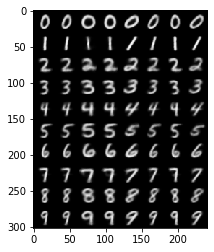

In [ ]:
plot_conditional_generation(cvae_lit.model, n=8)

**Remark**: 

After 15 epochs, VAE vanilla arrives at a **Reconstruction loss around 80**; KL divergence around 25;

CVAE arrives at a larger Reconstruction loss around 140; a much smaller KL divergence around 1.5;

That's why CVAE has a better generation property (the latent variables z is really close to standard gaussian) than VAE. But we can imagine the reconstruction property of CVAE is worse than VAE. 